In [25]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from torchtext.legacy.data import Field, TabularDataset, BucketIterator
import matplotlib.pyplot as plt

# dataset folder
source_folder = "solo_classification_REMI_dataset_unbalanced"
# where it saves the weights
destination_folder = "solo_classification_transformer_REMI_weights_unaugmented_200epochs"

In [26]:
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu" 
print(dev)
device = torch.device(dev)
print(device)

cuda:0
cuda:0


In [27]:
# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(tokenize=None, lower=True, include_lengths=True, batch_first=True)
fields = [('labels', label_field), ('notes', text_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=source_folder, train='train.csv', validation='val.csv', test='test.csv',
                                           format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=32, sort_key=lambda x: len(x.notes),
                            device=device, sort=False, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=32, sort_key=lambda x: len(x.notes),
                            device=device, sort=False, sort_within_batch=True)
test_iter = BucketIterator(test, batch_size=32, sort_key=lambda x: len(x.notes),
                            device=device, sort=False, sort_within_batch=True)

# Vocabulary

text_field.build_vocab(train, min_freq=1)

In [28]:
ntokens = len(text_field.vocab)
emsize = 200
d_hid = 64
nlayers = 2 
nhead = 8
dropout = 0.6

In [29]:
for (labels, (notes, notes_len)), _ in (train_iter):
    print(notes)

tensor([[ 4,  7, 30,  ...,  8, 63,  5],
        [ 4,  7, 30,  ..., 14, 56, 90],
        [ 4,  7, 30,  ..., 43,  3,  1],
        ...,
        [ 4,  7, 30,  ...,  1,  1,  1],
        [ 4,  7, 30,  ...,  1,  1,  1],
        [ 4,  7, 30,  ...,  1,  1,  1]], device='cuda:0')
tensor([[  4,   7,  30,  ...,  67,  60,   2],
        [  4,   7,  30,  ...,  16,  30, 132],
        [  4,   7,  30,  ...,  15,  23,   6],
        ...,
        [  4,   7,  30,  ...,   1,   1,   1],
        [  4,   7,  30,  ...,   1,   1,   1],
        [  4,   7,  58,  ...,   1,   1,   1]], device='cuda:0')
tensor([[  4,   7,  30,  ...,  59,  88,  89],
        [  4,   7,  58,  ...,   9,  31, 105],
        [  4,   7,  58,  ...,  47,  69,   1],
        ...,
        [  4,   7,  30,  ...,   1,   1,   1],
        [  4,   7,  30,  ...,   1,   1,   1],
        [  4,   7,  30,  ...,   1,   1,   1]], device='cuda:0')
tensor([[  4,   7,  30,  ...,  12,  68,   2],
        [  4,   7,  58,  ...,  31,  89,   1],
        [  4,   7,  30,

In [30]:
import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [31]:
import math
from typing import Tuple

import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

class TransformerModel(nn.Module):

    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, d_model)
        self.d_model = d_model
        self.decoder = nn.Linear(d_model, 2)
        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor) -> Tensor:
        """
        Args:
            src: Tensor, shape [seq_len, batch_size]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [seq_len, batch_size, ntoken]
        """
        src = self.encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = output.mean(dim=1)
        output = self.decoder(output)
        output = torch.sigmoid(output)
        return output
    
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [32]:
# Save and Load Functions https://towardsdatascience.com/lstm-text-classification-using-pytorch-2c6c657f8fc0

def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']


In [53]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.CrossEntropyLoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 10,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        total = 0
        total_correct = 0
        for (labels, (notes, notes_len)), _ in (train_loader):   
            labels = labels.to(device)
            notes = notes.to(device)
            notes_len = notes_len.cpu()
            output = model(notes.long())
            loss = criterion(output, labels.long())
            #loss = criterion(output.view(-1,1),labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            labels_max = labels.detach().cpu()
            output_max = np.argmax((output.detach().cpu()),axis=1)
            for i in range(len(labels_max)):
                total+=1
                if labels_max[i] ==  output_max[i]:
                    total_correct += 1
            accuracy = accuracy_score(labels_max, output_max)
            
            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                  # validation loop
                    for (labels, (notes, notes_len)), _ in (valid_loader):        
                        labels = labels.to(device)
                        notes = notes.to(device)
                        notes_len = notes_len.cpu()
                        output = model(notes.long())
                        loss = criterion(output, labels.long())
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/model.pt', model, optimizer, best_valid_loss)
                    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
        print("Epoch Accuracy: {}".format(total_correct/total))
    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')


model = TransformerModel(ntokens,emsize,nhead,d_hid,nlayers,dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00005)

train(model=model, optimizer=optimizer, num_epochs=500)

Epoch [1/500], Step [25/25000], Train Loss: 0.6639, Valid Loss: 0.6558
Model saved to ==> solo_classification_transformer_REMI_weights_unaugmented_200epochs/model.pt
Model saved to ==> solo_classification_transformer_REMI_weights_unaugmented_200epochs/metrics.pt
Epoch [1/500], Step [50/25000], Train Loss: 0.6670, Valid Loss: 0.6537
Model saved to ==> solo_classification_transformer_REMI_weights_unaugmented_200epochs/model.pt
Model saved to ==> solo_classification_transformer_REMI_weights_unaugmented_200epochs/metrics.pt
Epoch Accuracy: 0.6552598225602028
Epoch [2/500], Step [75/25000], Train Loss: 0.6039, Valid Loss: 0.6565
Epoch [2/500], Step [100/25000], Train Loss: 0.6875, Valid Loss: 0.6541
Epoch Accuracy: 0.6666666666666666
Epoch [3/500], Step [125/25000], Train Loss: 0.6491, Valid Loss: 0.6516
Model saved to ==> solo_classification_transformer_REMI_weights_unaugmented_200epochs/model.pt
Model saved to ==> solo_classification_transformer_REMI_weights_unaugmented_200epochs/metrics.

Epoch [26/500], Step [1300/25000], Train Loss: 0.5173, Valid Loss: 0.5177
Model saved to ==> solo_classification_transformer_REMI_weights_unaugmented_200epochs/model.pt
Model saved to ==> solo_classification_transformer_REMI_weights_unaugmented_200epochs/metrics.pt
Epoch Accuracy: 0.811787072243346
Epoch [27/500], Step [1325/25000], Train Loss: 0.5022, Valid Loss: 0.5369
Epoch [27/500], Step [1350/25000], Train Loss: 0.5024, Valid Loss: 0.5226
Epoch Accuracy: 0.8193916349809885
Epoch [28/500], Step [1375/25000], Train Loss: 0.4943, Valid Loss: 0.5371
Epoch [28/500], Step [1400/25000], Train Loss: 0.5069, Valid Loss: 0.5182
Epoch Accuracy: 0.820659062103929
Epoch [29/500], Step [1425/25000], Train Loss: 0.4922, Valid Loss: 0.5232
Epoch [29/500], Step [1450/25000], Train Loss: 0.4979, Valid Loss: 0.5274
Epoch Accuracy: 0.8212927756653993
Epoch [30/500], Step [1475/25000], Train Loss: 0.4869, Valid Loss: 0.5270
Epoch [30/500], Step [1500/25000], Train Loss: 0.5012, Valid Loss: 0.5136
Mode

Epoch [61/500], Step [3025/25000], Train Loss: 0.4651, Valid Loss: 0.4894
Epoch [61/500], Step [3050/25000], Train Loss: 0.4434, Valid Loss: 0.4803
Epoch Accuracy: 0.8643852978453739
Epoch [62/500], Step [3075/25000], Train Loss: 0.4378, Valid Loss: 0.4865
Epoch [62/500], Step [3100/25000], Train Loss: 0.4639, Valid Loss: 0.4698
Model saved to ==> solo_classification_transformer_REMI_weights_unaugmented_200epochs/model.pt
Model saved to ==> solo_classification_transformer_REMI_weights_unaugmented_200epochs/metrics.pt
Epoch Accuracy: 0.8650190114068441
Epoch [63/500], Step [3125/25000], Train Loss: 0.4381, Valid Loss: 0.4881
Epoch [63/500], Step [3150/25000], Train Loss: 0.4617, Valid Loss: 0.4748
Epoch Accuracy: 0.8662864385297845
Epoch [64/500], Step [3175/25000], Train Loss: 0.4317, Valid Loss: 0.4775
Epoch [64/500], Step [3200/25000], Train Loss: 0.4649, Valid Loss: 0.4972
Epoch Accuracy: 0.870722433460076
Epoch [65/500], Step [3225/25000], Train Loss: 0.4447, Valid Loss: 0.4756
Epo

Epoch [96/500], Step [4800/25000], Train Loss: 0.4194, Valid Loss: 0.4576
Epoch Accuracy: 0.9112801013941698
Epoch [97/500], Step [4825/25000], Train Loss: 0.4151, Valid Loss: 0.4446
Epoch [97/500], Step [4850/25000], Train Loss: 0.4175, Valid Loss: 0.4583
Epoch Accuracy: 0.9062103929024081
Epoch [98/500], Step [4875/25000], Train Loss: 0.4124, Valid Loss: 0.4642
Epoch [98/500], Step [4900/25000], Train Loss: 0.4139, Valid Loss: 0.4559
Epoch Accuracy: 0.9106463878326996
Epoch [99/500], Step [4925/25000], Train Loss: 0.4154, Valid Loss: 0.4419
Epoch [99/500], Step [4950/25000], Train Loss: 0.4183, Valid Loss: 0.4627
Epoch Accuracy: 0.9093789607097592
Epoch [100/500], Step [4975/25000], Train Loss: 0.4165, Valid Loss: 0.4555
Epoch [100/500], Step [5000/25000], Train Loss: 0.4088, Valid Loss: 0.4501
Epoch Accuracy: 0.9106463878326996
Epoch [101/500], Step [5025/25000], Train Loss: 0.4116, Valid Loss: 0.4578
Epoch [101/500], Step [5050/25000], Train Loss: 0.4163, Valid Loss: 0.4613
Epoch A

Epoch [138/500], Step [6875/25000], Train Loss: 0.4033, Valid Loss: 0.4445
Epoch [138/500], Step [6900/25000], Train Loss: 0.3902, Valid Loss: 0.4315
Epoch Accuracy: 0.9252217997465145
Epoch [139/500], Step [6925/25000], Train Loss: 0.3883, Valid Loss: 0.4566
Epoch [139/500], Step [6950/25000], Train Loss: 0.4072, Valid Loss: 0.4331
Epoch Accuracy: 0.9207858048162231
Epoch [140/500], Step [6975/25000], Train Loss: 0.3965, Valid Loss: 0.4471
Epoch [140/500], Step [7000/25000], Train Loss: 0.4000, Valid Loss: 0.4372
Epoch Accuracy: 0.9188846641318125
Epoch [141/500], Step [7025/25000], Train Loss: 0.4071, Valid Loss: 0.4469
Epoch [141/500], Step [7050/25000], Train Loss: 0.3933, Valid Loss: 0.4409
Epoch Accuracy: 0.9169835234474017
Epoch [142/500], Step [7075/25000], Train Loss: 0.3924, Valid Loss: 0.4375
Epoch [142/500], Step [7100/25000], Train Loss: 0.3993, Valid Loss: 0.4639
Epoch Accuracy: 0.9258555133079848
Epoch [143/500], Step [7125/25000], Train Loss: 0.4011, Valid Loss: 0.4440


Epoch [181/500], Step [9050/25000], Train Loss: 0.3827, Valid Loss: 0.4450
Epoch Accuracy: 0.9271229404309252
Epoch [182/500], Step [9075/25000], Train Loss: 0.3891, Valid Loss: 0.4579
Epoch [182/500], Step [9100/25000], Train Loss: 0.3916, Valid Loss: 0.4413
Epoch Accuracy: 0.9283903675538656
Epoch [183/500], Step [9125/25000], Train Loss: 0.3843, Valid Loss: 0.4521
Epoch [183/500], Step [9150/25000], Train Loss: 0.3925, Valid Loss: 0.4388
Epoch Accuracy: 0.9290240811153359
Epoch [184/500], Step [9175/25000], Train Loss: 0.3908, Valid Loss: 0.4399
Epoch [184/500], Step [9200/25000], Train Loss: 0.3858, Valid Loss: 0.4550
Epoch Accuracy: 0.9271229404309252
Epoch [185/500], Step [9225/25000], Train Loss: 0.3940, Valid Loss: 0.4362
Epoch [185/500], Step [9250/25000], Train Loss: 0.3853, Valid Loss: 0.4676
Epoch Accuracy: 0.9271229404309252
Epoch [186/500], Step [9275/25000], Train Loss: 0.4082, Valid Loss: 0.4543
Epoch [186/500], Step [9300/25000], Train Loss: 0.3834, Valid Loss: 0.4483


Epoch [225/500], Step [11225/25000], Train Loss: 0.3848, Valid Loss: 0.4400
Epoch [225/500], Step [11250/25000], Train Loss: 0.3896, Valid Loss: 0.4521
Epoch Accuracy: 0.9277566539923955
Epoch [226/500], Step [11275/25000], Train Loss: 0.3930, Valid Loss: 0.4471
Epoch [226/500], Step [11300/25000], Train Loss: 0.3772, Valid Loss: 0.4464
Epoch Accuracy: 0.9315589353612167
Epoch [227/500], Step [11325/25000], Train Loss: 0.3844, Valid Loss: 0.4586
Epoch [227/500], Step [11350/25000], Train Loss: 0.3882, Valid Loss: 0.4545
Epoch Accuracy: 0.9277566539923955
Epoch [228/500], Step [11375/25000], Train Loss: 0.3875, Valid Loss: 0.4380
Epoch [228/500], Step [11400/25000], Train Loss: 0.3896, Valid Loss: 0.4406
Epoch Accuracy: 0.9207858048162231
Epoch [229/500], Step [11425/25000], Train Loss: 0.3901, Valid Loss: 0.4528
Epoch [229/500], Step [11450/25000], Train Loss: 0.3817, Valid Loss: 0.4500
Epoch Accuracy: 0.9258555133079848
Epoch [230/500], Step [11475/25000], Train Loss: 0.3903, Valid Lo

Epoch [269/500], Step [13425/25000], Train Loss: 0.3818, Valid Loss: 0.4536
Epoch [269/500], Step [13450/25000], Train Loss: 0.3872, Valid Loss: 0.4354
Epoch Accuracy: 0.9302915082382763
Epoch [270/500], Step [13475/25000], Train Loss: 0.3755, Valid Loss: 0.4499
Epoch [270/500], Step [13500/25000], Train Loss: 0.3879, Valid Loss: 0.4466
Epoch Accuracy: 0.9328263624841572
Epoch [271/500], Step [13525/25000], Train Loss: 0.3801, Valid Loss: 0.4532
Epoch [271/500], Step [13550/25000], Train Loss: 0.3800, Valid Loss: 0.4497
Epoch Accuracy: 0.9328263624841572
Epoch [272/500], Step [13575/25000], Train Loss: 0.3803, Valid Loss: 0.4368
Epoch [272/500], Step [13600/25000], Train Loss: 0.3874, Valid Loss: 0.4495
Epoch Accuracy: 0.9328263624841572
Epoch [273/500], Step [13625/25000], Train Loss: 0.3800, Valid Loss: 0.4472
Epoch [273/500], Step [13650/25000], Train Loss: 0.3815, Valid Loss: 0.4489
Epoch Accuracy: 0.9385297845373891
Epoch [274/500], Step [13675/25000], Train Loss: 0.3781, Valid Lo

Epoch [312/500], Step [15575/25000], Train Loss: 0.3883, Valid Loss: 0.4347
Epoch [312/500], Step [15600/25000], Train Loss: 0.3622, Valid Loss: 0.4356
Epoch Accuracy: 0.9416983523447402
Epoch [313/500], Step [15625/25000], Train Loss: 0.3800, Valid Loss: 0.4264
Model saved to ==> solo_classification_transformer_REMI_weights_unaugmented_200epochs/model.pt
Model saved to ==> solo_classification_transformer_REMI_weights_unaugmented_200epochs/metrics.pt
Epoch [313/500], Step [15650/25000], Train Loss: 0.3810, Valid Loss: 0.4324
Epoch Accuracy: 0.9340937896070975
Epoch [314/500], Step [15675/25000], Train Loss: 0.3870, Valid Loss: 0.4360
Epoch [314/500], Step [15700/25000], Train Loss: 0.3741, Valid Loss: 0.4226
Model saved to ==> solo_classification_transformer_REMI_weights_unaugmented_200epochs/model.pt
Model saved to ==> solo_classification_transformer_REMI_weights_unaugmented_200epochs/metrics.pt
Epoch Accuracy: 0.9340937896070975
Epoch [315/500], Step [15725/25000], Train Loss: 0.3749

Epoch [353/500], Step [17625/25000], Train Loss: 0.3924, Valid Loss: 0.4359
Epoch [353/500], Step [17650/25000], Train Loss: 0.3629, Valid Loss: 0.4400
Epoch Accuracy: 0.9359949302915083
Epoch [354/500], Step [17675/25000], Train Loss: 0.3663, Valid Loss: 0.4517
Epoch [354/500], Step [17700/25000], Train Loss: 0.3829, Valid Loss: 0.4443
Epoch Accuracy: 0.9404309252217997
Epoch [355/500], Step [17725/25000], Train Loss: 0.3847, Valid Loss: 0.4280
Epoch [355/500], Step [17750/25000], Train Loss: 0.3723, Valid Loss: 0.4382
Epoch Accuracy: 0.935361216730038
Epoch [356/500], Step [17775/25000], Train Loss: 0.3751, Valid Loss: 0.4463
Epoch [356/500], Step [17800/25000], Train Loss: 0.3830, Valid Loss: 0.4288
Epoch Accuracy: 0.9359949302915083
Epoch [357/500], Step [17825/25000], Train Loss: 0.3799, Valid Loss: 0.4491
Epoch [357/500], Step [17850/25000], Train Loss: 0.3764, Valid Loss: 0.4391
Epoch Accuracy: 0.9378960709759189
Epoch [358/500], Step [17875/25000], Train Loss: 0.3786, Valid Los

Epoch [396/500], Step [19775/25000], Train Loss: 0.3767, Valid Loss: 0.4377
Epoch [396/500], Step [19800/25000], Train Loss: 0.3768, Valid Loss: 0.4337
Epoch Accuracy: 0.9404309252217997
Epoch [397/500], Step [19825/25000], Train Loss: 0.3885, Valid Loss: 0.4334
Epoch [397/500], Step [19850/25000], Train Loss: 0.3623, Valid Loss: 0.4403
Epoch Accuracy: 0.9397972116603295
Epoch [398/500], Step [19875/25000], Train Loss: 0.3706, Valid Loss: 0.4280
Epoch [398/500], Step [19900/25000], Train Loss: 0.3768, Valid Loss: 0.4368
Epoch Accuracy: 0.9423320659062104
Epoch [399/500], Step [19925/25000], Train Loss: 0.3791, Valid Loss: 0.4332
Epoch [399/500], Step [19950/25000], Train Loss: 0.3691, Valid Loss: 0.4388
Epoch Accuracy: 0.9423320659062104
Epoch [400/500], Step [19975/25000], Train Loss: 0.3730, Valid Loss: 0.4363
Epoch [400/500], Step [20000/25000], Train Loss: 0.3796, Valid Loss: 0.4417
Epoch Accuracy: 0.9378960709759189
Epoch [401/500], Step [20025/25000], Train Loss: 0.3767, Valid Lo

Epoch [440/500], Step [21975/25000], Train Loss: 0.3757, Valid Loss: 0.4369
Epoch [440/500], Step [22000/25000], Train Loss: 0.3713, Valid Loss: 0.4293
Epoch Accuracy: 0.9435994930291508
Epoch [441/500], Step [22025/25000], Train Loss: 0.3678, Valid Loss: 0.4303
Epoch [441/500], Step [22050/25000], Train Loss: 0.3838, Valid Loss: 0.4315
Epoch Accuracy: 0.9372623574144486
Epoch [442/500], Step [22075/25000], Train Loss: 0.3797, Valid Loss: 0.4443
Epoch [442/500], Step [22100/25000], Train Loss: 0.3652, Valid Loss: 0.4326
Epoch Accuracy: 0.9423320659062104
Epoch [443/500], Step [22125/25000], Train Loss: 0.3679, Valid Loss: 0.4347
Epoch [443/500], Step [22150/25000], Train Loss: 0.3752, Valid Loss: 0.4315
Epoch Accuracy: 0.944233206590621
Epoch [444/500], Step [22175/25000], Train Loss: 0.3676, Valid Loss: 0.4336
Epoch [444/500], Step [22200/25000], Train Loss: 0.3777, Valid Loss: 0.4250
Epoch Accuracy: 0.9435994930291508
Epoch [445/500], Step [22225/25000], Train Loss: 0.3741, Valid Los

Epoch [484/500], Step [24175/25000], Train Loss: 0.3701, Valid Loss: 0.4376
Epoch [484/500], Step [24200/25000], Train Loss: 0.3687, Valid Loss: 0.4406
Epoch Accuracy: 0.9467680608365019
Epoch [485/500], Step [24225/25000], Train Loss: 0.3758, Valid Loss: 0.4283
Epoch [485/500], Step [24250/25000], Train Loss: 0.3712, Valid Loss: 0.4440
Epoch Accuracy: 0.9404309252217997
Epoch [486/500], Step [24275/25000], Train Loss: 0.3768, Valid Loss: 0.4319
Epoch [486/500], Step [24300/25000], Train Loss: 0.3623, Valid Loss: 0.4407
Epoch Accuracy: 0.9474017743979721
Epoch [487/500], Step [24325/25000], Train Loss: 0.3777, Valid Loss: 0.4309
Epoch [487/500], Step [24350/25000], Train Loss: 0.3650, Valid Loss: 0.4390
Epoch Accuracy: 0.9429657794676806
Epoch [488/500], Step [24375/25000], Train Loss: 0.3671, Valid Loss: 0.4407
Epoch [488/500], Step [24400/25000], Train Loss: 0.3783, Valid Loss: 0.4419
Epoch Accuracy: 0.9423320659062104
Epoch [489/500], Step [24425/25000], Train Loss: 0.3800, Valid Lo

In [40]:
# torch.backends.cudnn.enabled = False

Model loaded from <== solo_classification_transformer_REMI_weights_unaugmented_200epochs/metrics.pt
500
500
500


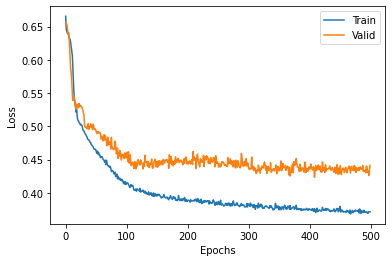

In [55]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
epoch_train = []
epoch_valid = []
epochs = []

for x in range(0, len(train_loss_list), 2):
    epoch_train.append(sum(train_loss_list[x:x+2])/len(train_loss_list[x:x+2]))
print(len(epoch_train))

for x in range(0, len(valid_loss_list), 2):
    epoch_valid.append(sum(valid_loss_list[x:x+2])/len(valid_loss_list[x:x+2]))
print(len(epoch_valid))

for x in range(500):
    epochs.append(x)
print(len(epochs))

plt.plot(epochs, epoch_train, label='Train')
plt.plot(epochs, epoch_valid, label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("Transformer 500 epochs.png")
plt.show() 

In [17]:
print(global_steps_list)

[25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675, 700, 725, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000, 1025, 1050, 1075, 1100, 1125, 1150, 1175, 1200, 1225, 1250, 1275, 1300, 1325, 1350, 1375, 1400, 1425, 1450, 1475, 1500, 1525, 1550, 1575, 1600, 1625, 1650, 1675, 1700, 1725, 1750, 1775, 1800, 1825, 1850, 1875, 1900, 1925, 1950, 1975, 2000, 2025, 2050, 2075, 2100, 2125, 2150, 2175, 2200, 2225, 2250, 2275, 2300, 2325, 2350, 2375, 2400, 2425, 2450, 2475, 2500, 2525, 2550, 2575, 2600, 2625, 2650, 2675, 2700, 2725, 2750, 2775, 2800, 2825, 2850, 2875, 2900, 2925, 2950, 2975, 3000, 3025, 3050, 3075, 3100, 3125, 3150, 3175, 3200, 3225, 3250, 3275, 3300, 3325, 3350, 3375, 3400, 3425, 3450, 3475, 3500, 3525, 3550, 3575, 3600, 3625, 3650, 3675, 3700, 3725, 3750, 3775, 3800, 3825, 3850, 3875, 3900, 3925, 3950, 3975, 4000, 4025, 4050, 4075, 4100, 4125, 4150, 4175, 4200, 4225, 4250, 4275, 4300, 4325, 435

Model loaded from <== solo_classification_transformer_REMI_weights_unaugmented_200epochs/metrics.pt


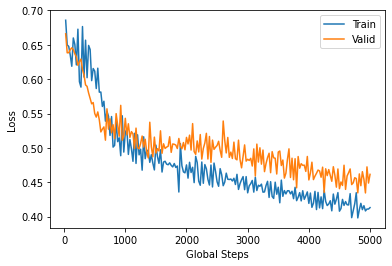

In [47]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
#plt.savefig("Transformer 200 epochs.png")
plt.show() 

In [36]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

Model loaded from <== solo_classification_transformer_REMI_weights_unaugmented_200epochs/model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.7869    0.8571    0.8205       112
           0     0.9252    0.8839    0.9041       224

    accuracy                         0.8750       336
   macro avg     0.8561    0.8705    0.8623       336
weighted avg     0.8791    0.8750    0.8762       336



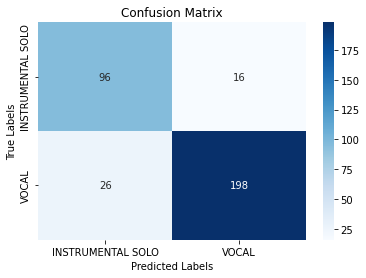

In [56]:
def evaluate(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, (notes, notes_len)), _ in test_loader:           
            labels = labels.to(device)
            notes = notes.to(device)
            notes_len = notes_len.cpu()
            output = model(notes.long())

            output = np.argmax(output.cpu().detach(), axis=1)
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['INSTRUMENTAL SOLO', 'VOCAL'])
    ax.yaxis.set_ticklabels(['INSTRUMENTAL SOLO', 'VOCAL'])
    
    
best_model = TransformerModel(ntokens,emsize,nhead,d_hid,nlayers,dropout).to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

load_checkpoint(destination_folder + '/model.pt', best_model, optimizer)
evaluate(best_model, test_iter)

In [14]:
from torchviz import make_dot
import hiddenlayer as hl

ModuleNotFoundError: No module named 'torchviz'

In [ ]:
next(iter(test_iter)).notes

In [ ]:
def print_architecture(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    for (labels, (notes, notes_len)), _ in test_loader:           
        labels = labels.to(device)
        notes = notes.to(device)
        notes_len = notes_len.cpu()
        output = model(notes.long(), notes_len.long())
        
        
        transforms = [# hl.transforms.Prune('Constant'),
                      #hl.transforms.FoldDuplicates()
                     ] # Removes Constant nodes from graph.

        graph = hl.build_graph(model, (notes,notes_len), transforms=transforms)
        graph.theme = hl.graph.THEMES['blue'].copy()
        print(graph)
        graph.save('rnn_hiddenlayer', format='png')

        #output = (output > threshold).int()
        #y_pred.extend(output.tolist())
        #y_true.extend(labels.tolist())
        #print(dict(model.named_parameters()))
        #make_dot(output,params=dict(model.named_parameters())).render()
        break

    
best_model = LSTM().to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

load_checkpoint(destination_folder + '/model.pt', best_model, optimizer)
print_architecture(best_model, test_iter)

In [ ]:
# print(best_model)